# Minimum Eigen Optimizer


## Introduction

An interesting class of optimization problems to be addressed by quantum computing are Quadratic Unconstrained Binary Optimization (QUBO) problems.
Finding the solution to a QUBO is equivalent to finding the ground state of a corresponding Ising Hamiltonian, which is an important problem not only in optimization, but also in quantum chemistry and physics. For this translation, the binary variables taking values in $\{0, 1\}$ are replaced by spin variables taking values in $\{-1, +1\}$, which allows to replace the resulting spin variables by Pauli Z matrices, and thus, an Ising Hamiltonian. For more details on this mapping we refer to [1].

Qiskit provides automatic conversion from a suitable `QuadraticProgram` to an Ising Hamiltonian, which then allows to leverage all the `MinimumEigenSolver` such as
- `VQE`,
- `QAOA`, or
- `NumpyMinimumEigensolver` (classical exact method).

Qiskit wraps the translation to an Ising Hamiltonian (in Qiskit Aqua also called `Operator`), the call to an `MinimumEigensolver` as well as the translation of the results back to `OptimizationResult` in the `MinimumEigenOptimizer`.

In the following we first illustrate the conversion from a `QuadraticProgram` to an `Operator` and then show how to use the `MinimumEigenOptimizer` with different `MinimumEigensolver` to solve a given `QuadraticProgram`.
The algorithms in Qiskit automatically try to convert a given problem to the supported problem class if possible, for instance, the `MinimumEigenOptimizer` will automatically translate integer variables to binary variables or add a linear equality constraints as a quadratic penalty term to the objective. It should be mentioned that Aqua will through a `QiskitOptimizationError` if conversion of a quadratic program with integer variable is attempted.

The circuit depth of `QAOA` potentially has to be increased with the problem size, which might be prohibitive for near-term quantum devices.
A possible workaround is Recursive QAOA, as introduced in [2].
Qiskit generalizes this concept to the `RecursiveMinimumEigenOptimizer`, which is introduced at the end of this tutorial.

### References
[1] [A. Lucas, *Ising formulations of many NP problems,* Front. Phys., 12 (2014).](https://arxiv.org/abs/1302.5843)

[2] [S. Bravyi, A. Kliesch, R. Koenig, E. Tang, *Obstacles to State Preparation and Variational Optimization from Symmetry Protection,* arXiv  preprint arXiv:1910.08980 (2019).](https://arxiv.org/abs/1910.08980)

## Converting a QUBO to an Operator

In [23]:
from qiskit import BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, SolutionSample, OptimizationResultStatus
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

In [24]:
# create a QUBO
qubo = QuadraticProgram()
qubo.binary_var('x')
qubo.binary_var('y')
qubo.binary_var('z')
qubo.minimize(linear=[1,-2,3], quadratic={('x', 'y'): 1, ('x', 'z'): -1, ('y', 'z'): 2})
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x - 2 y + 3 z + [ 2 x*y - 2 x*z + 4 y*z ]/2
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



Next we translate this QUBO into an Ising operator. This results not only in an `Operator` but also in a constant offset to be taking into account to shift the resulting value.

In [25]:
op, offset = qubo.to_ising()
print('offset: {}'.format(offset))
print('operator:')
print(op)

offset: 1.5
operator:
-1.75 * ZII
+ 0.25 * IZI
+ 0.5 * ZZI
- 0.5 * IIZ
- 0.25 * ZIZ
+ 0.25 * IZZ


Sometimes an `QuadraticProgram` might also directly be given in the form of an `Operator`. For such cases, Qiskit also provides a converter from an `Operator` back to a `QuadraticProgram`, which we illustrate in the following.

In [26]:
qp=QuadraticProgram()
qp.from_ising(op, offset, linear=True)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x_0 - 2 x_1 + 3 x_2 + [ 2 x_0*x_1 - 2 x_0*x_2 + 4 x_1*x_2 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1

Binaries
 x_0 x_1 x_2
End



This converter allows, for instance, to translate an `Operator` to a `QuadraticProgram` and then solve the problem with other algorithms that are not based on the Ising Hamiltonian representation, such as the `GroverOptimizer`.

## Solving a QUBO with the MinimumEigenOptimizer

We start by initializing the `MinimumEigensolver` we want to use.

In [27]:
algorithm_globals.random_seed = 10598
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                   seed_simulator=algorithm_globals.random_seed,
                                   seed_transpiler=algorithm_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.])
exact_mes = NumPyMinimumEigensolver()

Then, we use the `MinimumEigensolver` to create `MinimumEigenOptimizer`.

In [28]:
qaoa = MinimumEigenOptimizer(qaoa_mes)   # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

We first use the `MinimumEigenOptimizer` based on the classical exact `NumPyMinimumEigensolver` to get the optimal benchmark solution for this small example.

In [29]:
exact_result = exact.solve(qubo)
print(exact_result)

optimal function value: -2.0
optimal value: [0. 1. 0.]
status: SUCCESS


Next we apply the `MinimumEigenOptimizer` based on `QAOA` to the same problem.

In [30]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)

optimal function value: -2.0
optimal value: [0. 1. 0.]
status: SUCCESS


### Analysis of Samples
`OptimizationResult` provides a useful information source `SolutionSample` (here denoted as *samples*). They contain
information about input values `x`, objective function values `fval`, probability of obtaining that result `probability`
and the solution status `status` (`SUCCESS`, `FAILURE`, `INFEASIBLE`).

In [31]:
print('variable order:', [var.name for var in qaoa_result.variables])
for s in qaoa_result.samples:
    print(s)

variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.1249999999999999

We may also want to filter samples according to their status or probabilities.

In [32]:
def get_filtered_samples(samples: List[SolutionSample],
                         threshold: float = 0,
                         allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,)):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [33]:
filtered_samples = get_filtered_samples(qaoa_result.samples,
                                        threshold=0.005,
                                        allowed_status=(OptimizationResultStatus.SUCCESS,))
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.12499999999999994, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.12499999999999994, status=<OptimizationResultSta

If we want to obtain a better perspective of the results, statistics is very helpful, both with respect to
the objective function values and their respective probabilities. Thus, mean and standard deviation are the very
basics for understanding the results.

In [34]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [35]:
np.mean(fvals)

1.5

In [36]:
np.std(fvals)

1.9364916731037085

Finally, despite all number-crunching, visualization is usually the best early-analysis approach.

In [37]:
samples_for_plot = {' '.join(f'{qaoa_result.variables[i].name}={int(v)}'
                             for i, v in enumerate(s.x)): s.probability
                    for s in filtered_samples}
samples_for_plot

{'x=0 y=1 z=0': 0.12499999999999994,
 'x=0 y=0 z=0': 0.12499999999999994,
 'x=1 y=1 z=0': 0.12499999999999994,
 'x=1 y=0 z=0': 0.12499999999999994,
 'x=0 y=0 z=1': 0.12499999999999994,
 'x=1 y=0 z=1': 0.12499999999999994,
 'x=0 y=1 z=1': 0.12499999999999994,
 'x=1 y=1 z=1': 0.12499999999999994}

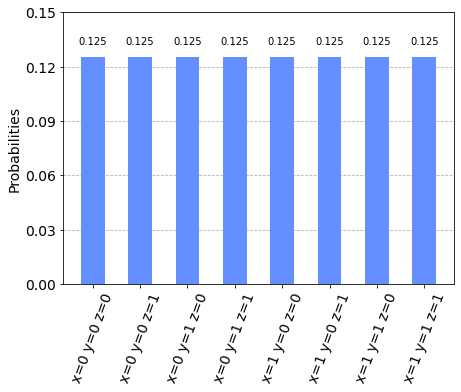

In [38]:
plot_histogram(samples_for_plot)

## RecursiveMinimumEigenOptimizer

The `RecursiveMinimumEigenOptimizer` takes a `MinimumEigenOptimizer` as input and applies the recursive optimization scheme to reduce the size of the problem one variable at a time.
Once the size of the generated intermediate problem is below a given threshold (`min_num_vars`), the `RecursiveMinimumEigenOptimizer` uses another solver (`min_num_vars_optimizer`), e.g., an exact classical solver such as CPLEX or the `MinimumEigenOptimizer` based on the `NumPyMinimumEigensolver`.

In the following, we show how to use the `RecursiveMinimumEigenOptimizer` using the two `MinimumEigenOptimizer` introduced before.

First, we construct the `RecursiveMinimumEigenOptimizer` such that it reduces the problem size from 3 variables to 1 variable and then uses the exact solver for the last variable. Then we call `solve` to optimize the considered problem.

In [39]:
rqaoa = RecursiveMinimumEigenOptimizer(qaoa, min_num_vars=1, min_num_vars_optimizer=exact)

In [40]:
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result)

optimal function value: -2.0
optimal value: [0. 1. 0.]
status: SUCCESS


In [41]:
filtered_samples = get_filtered_samples(rqaoa_result.samples,
                                        threshold=0.005,
                                        allowed_status=(OptimizationResultStatus.SUCCESS,))

In [42]:
samples_for_plot = {' '.join(f'{rqaoa_result.variables[i].name}={int(v)}' 
                             for i, v in enumerate(s.x)): s.probability 
                    for s in filtered_samples}
samples_for_plot

{'x=0 y=1 z=0': 1.0}

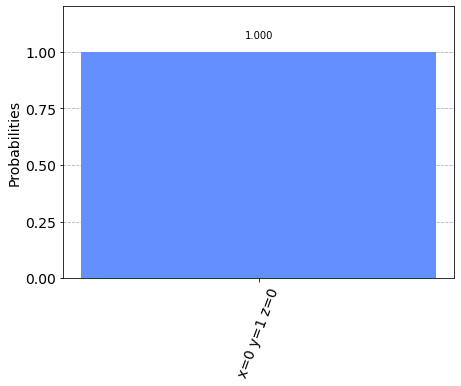

In [43]:
plot_histogram(samples_for_plot)

In [44]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright